In [2]:
!mkdir -p ./data; cd ./data; wget -q --show-progress https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2
!cd ./data; tar xjf LJSpeech-1.1.tar.bz2

LJSpeech-1.1.tar.bz 100%[===================>]   2.56G   141MB/s    in 28s     


In [17]:
from trainModel import train

In [18]:
train()

In [24]:
import os
import time

import torch

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from params import p
from dataset import TTSDataset, textMelCollateFn
from model import TTSLoss
from model import TransformerTTS
from melSpectogram import inverse_mel_spec_to_wav
from textTransform import textToSeq


def batch_process(batch):
	text_padded, text_lengths, mel_padded, mel_lengths, stop_token_padded = batch

	text_padded = text_padded.cuda()
	text_lengths = text_lengths.cuda()
	mel_padded = mel_padded.cuda()
	stop_token_padded = stop_token_padded.cuda()
	mel_lengths = mel_lengths.cuda()

	mel_input = torch.cat([torch.zeros((mel_padded.shape[0], 1, p.mel_freq), device=mel_padded.device), mel_padded[:, :-1, :]], dim=1)

	return text_padded, text_lengths, mel_padded, mel_lengths, mel_input, stop_token_padded



def inference_utterance(model, text):
	sequences = textToSeq(text).unsqueeze(0).cuda()
	postnet_mel, stop_token = model.inference(
		sequences,
		stop_token_threshold=1e5,
		with_tqdm = False
	)
	audio = inverse_mel_spec_to_wav(postnet_mel.detach()[0].T)

	fig, (ax1) = plt.subplots(1, 1)
	ax1.imshow(
		postnet_mel[0, :, :].detach().cpu().numpy().T,
	)

	return audio, fig


def calculate_test_loss(model, test_loader, criterion):
	test_loss_mean = 0.0
	model.eval()

	with torch.no_grad():
		for test_i, test_batch in enumerate(test_loader):
			test_text_padded, test_text_lengths, test_mel_padded, test_mel_lengths, test_mel_input, test_stop_token_padded = batch_process(test_batch)

			test_post_mel_out, test_mel_out, test_stop_token_out = model(test_text_padded, test_text_lengths, test_mel_input, test_mel_lengths)
			test_loss = criterion(mel_postnet_out = test_post_mel_out, mel_out = test_mel_out, stop_token_out = test_stop_token_out, mel_target = test_mel_padded, stop_token_target = test_stop_token_padded)

			test_loss_mean += test_loss.item()

	test_loss_mean = test_loss_mean / (test_i + 1)
	return test_loss_mean



def train():
	df = pd.read_csv("data/LJSpeech-1.1/metadata.csv")

	#num_rows_to_drop = int(len(df) * 0.9)
	#df = df.drop(df.sample(n=num_rows_to_drop).index)

	train_df, test_df = train_test_split(df, test_size=65)
	train_loader = torch.utils.data.DataLoader(TTSDataset(train_df), num_workers=2, shuffle=True, batch_size=p.batch_size, pin_memory=True, drop_last=True, collate_fn=textMelCollateFn)
	test_loader = torch.utils.data.DataLoader(TTSDataset(test_df), num_workers=2, shuffle=True, batch_size=8, pin_memory=True, drop_last=True,  collate_fn=textMelCollateFn)

	train_saved_path = "data/models/best_train_model"
	test_saved_path = "data/models/best_test_model"

	criterion = TTSLoss().cuda()
	model = TransformerTTS().cuda()
	optimizer = torch.optim.AdamW(model.parameters(), lr=p.lr)
	scaler = torch.cuda.amp.GradScaler()

	best_test_loss_mean = float("inf")
	best_train_loss_mean = float("inf")

	train_loss_mean = 0.0
	epoch = 0
	i = 0

	first_start_time_sec = time.time()
	start_time_sec = time.time()

	while time.time() - first_start_time_sec < 3600:
		for batch in train_loader:
			text_padded, text_lengths, mel_padded, mel_lengths, mel_input, stop_token_padded = batch_process(batch)

			model.train(True)
			model.zero_grad()

			with torch.autocast(device_type='cuda', dtype=torch.float16):
				post_mel_out, mel_out, stop_token_out = model(text_padded, text_lengths, mel_input, mel_lengths)
				loss = criterion(mel_postnet_out = post_mel_out, mel_out = mel_out, stop_token_out = stop_token_out, mel_target = mel_padded, stop_token_target = stop_token_padded)

			scaler.scale(loss).backward()
			scaler.unscale_(optimizer)
			torch.nn.utils.clip_grad_norm_(model.parameters(), p.grad_clip)
			scaler.step(optimizer)
			scaler.update()

			train_loss_mean += loss.item()


			if i % 100 == 0:
				train_loss_mean = train_loss_mean / p.step_print

				if i % 1000 == 0:
					test_loss_mean = calculate_test_loss(model, test_loader, criterion)
					audio, fig = inference_utterance(model, "Hello, World.")

					print(f"{epoch}-{i}) Test loss: {np.round(test_loss_mean, 5)}")

					if i % 1000 == 0:
						is_best_train = train_loss_mean < best_train_loss_mean
						is_best_test = test_loss_mean < best_test_loss_mean

						state = {
							"model": model.state_dict(), "optimizer": optimizer.state_dict(), "i": i, "test_loss": test_loss_mean, "train_loss": train_loss_mean}

						if is_best_train:
							print(f"{epoch}-{i}) Save best train")
							torch.save(state, train_saved_path)
							best_train_loss_mean = train_loss_mean

						if is_best_test:
							print(f"{epoch}-{i}) Save best test")
							torch.save(state, test_saved_path)
							best_test_loss_mean = test_loss_mean


				end_time_sec = time.time()
				time_sec = np.round(end_time_sec - start_time_sec, 3)
				start_time_sec = end_time_sec

				print(f"{epoch}-{i}) Train loss: {np.round(train_loss_mean, 5)}; Duration: {time_sec} sec.")
				train_loss_mean = 0.0

			i += 1
		epoch += 1


<ipython-input-24-4b22dba63222>:85: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


0-0) Test loss: 13.49439
0-0) Save best train
0-0) Save best test
0-0) Train loss: 0.01347; Duration: 12.197 sec.
0-100) Train loss: 0.33684; Duration: 63.924 sec.
0-200) Train loss: 0.15199; Duration: 65.916 sec.
0-300) Train loss: 0.11731; Duration: 66.561 sec.
0-400) Train loss: 0.10605; Duration: 66.306 sec.
1-500) Train loss: 0.10042; Duration: 65.453 sec.
1-600) Train loss: 0.09533; Duration: 67.311 sec.
1-700) Train loss: 0.09132; Duration: 66.543 sec.
1-800) Train loss: 0.0877; Duration: 66.11 sec.
2-900) Train loss: 0.08552; Duration: 65.098 sec.
2-1000) Test loss: 0.83473
2-1000) Save best test
2-1000) Train loss: 0.08433; Duration: 76.061 sec.
2-1100) Train loss: 0.08201; Duration: 63.879 sec.
2-1200) Train loss: 0.08002; Duration: 67.902 sec.
3-1300) Train loss: 0.07924; Duration: 68.143 sec.
3-1400) Train loss: 0.07794; Duration: 65.17 sec.
3-1500) Train loss: 0.07617; Duration: 66.216 sec.
3-1600) Train loss: 0.07627; Duration: 65.06 sec.
4-1700) Train loss: 0.07487; Dura

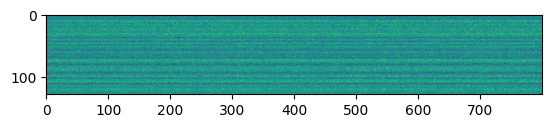

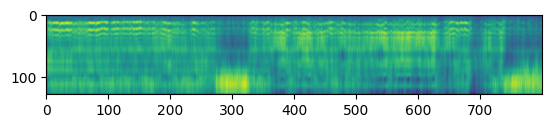

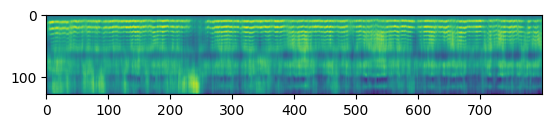

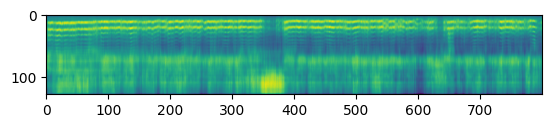

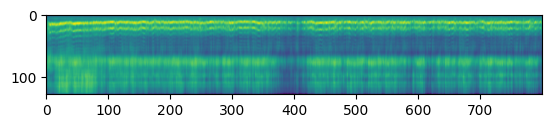

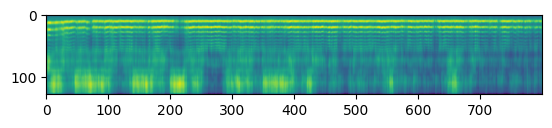

In [25]:
train()